In [1]:
import rasterio
import numpy as np
import os

# Computing Features from sentinel

In [4]:
stack_path = "tehri_landslide/data/sentinel_stacked/tehri_stack.tif"  # your multiband raster
output_dir = "tehri_landslide/data/sentinel_features/"
os.makedirs(output_dir, exist_ok=True)

In [5]:
with rasterio.open(stack_path) as src:
    stack = src.read()  # shape: (bands, height, width)
    profile = src.profile.copy()

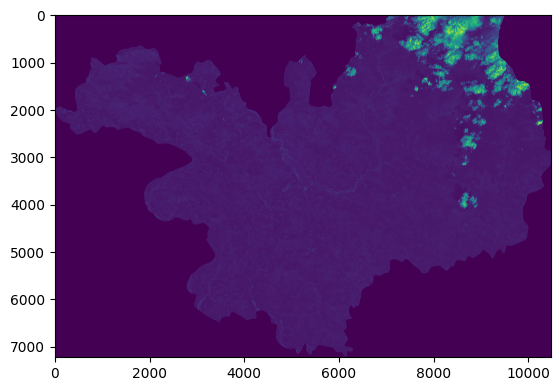

In [9]:
import matplotlib.pyplot as plt
plt.imshow(stack[1])
plt.show()

In [6]:
B02 = stack[0].astype(float)  # Blue
B03 = stack[1].astype(float)  # Green
B04 = stack[2].astype(float)  # Red
B08 = stack[3].astype(float)  # NIR

In [7]:
ndvi = (B08 - B04) / (B08 + B04)
ndvi = np.nan_to_num(ndvi, nan=-9999)  # replace NaN with -9999

C:\Users\sangh\AppData\Local\Temp\ipykernel_19908\3548667201.py:1: RuntimeWarning: invalid value encountered in divide
  ndvi = (B08 - B04) / (B08 + B04)


In [10]:
ndvi_path = os.path.join(output_dir, "NDVI.tif")
profile.update(dtype=rasterio.float32, count=1, nodata=-9999)
with rasterio.open(ndvi_path, "w", **profile) as dst:
    dst.write(ndvi.astype(rasterio.float32), 1)

In [11]:
print(f"NDVI saved: {ndvi_path}")

NDVI saved: tehri_landslide/data/sentinel_features/NDVI.tif


In [12]:
# -- NDWI = (Green - NIR) / (Green + NIR)
ndwi = (B03 - B08) / (B03 + B08)
ndwi = np.nan_to_num(ndwi, nan=-9999)

C:\Users\sangh\AppData\Local\Temp\ipykernel_19908\1038047177.py:2: RuntimeWarning: invalid value encountered in divide
  ndwi = (B03 - B08) / (B03 + B08)


In [13]:
ndwi_path = os.path.join(output_dir, "NDWI.tif")
with rasterio.open(ndwi_path, "w", **profile) as dst:
    dst.write(ndwi.astype(rasterio.float32), 1)

In [14]:
print(f"NDWI saved: {ndwi_path}")

NDWI saved: tehri_landslide/data/sentinel_features/NDWI.tif


# Computing features from DEM

In [1]:
import rasterio
import numpy as np

In [2]:
dem_path = "tehri_landslide/data/DEM/dem_fixed.tif"

In [10]:

import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

with rasterio.open(dem_path) as src:
    dem = src.read(1).astype(float)
    nodata = src.nodata
    res_x = src.transform.a  # Horizontal resolution
    crs = src.crs

# 2. Clean the data
# Masking typical NoData values or outliers
dem_clean = np.where((dem < -100) | (dem > 9000), np.nan, dem)

# 3. Handle the "Empty Hillshade" Problem
# We create a 'filled' version just for the math, so NaNs don't break the light calculation
dem_filled = np.nan_to_num(dem_clean, nan=np.nanmedian(dem_clean))

# 4. Determine Vertical Exaggeration (Crucial Step)
# If your CRS is in Degrees (EPSG:4326), res_x will be a tiny decimal (e.g. 0.0008).
# We need to stretch the shadows significantly to see them.
if res_x < 0.1:
    v_exag = 100  # Stretch for Degrees
else:
    v_exag = 2    # Standard for Meters (UTM)

# 5. Create the Visualization
ls = LightSource(azdeg=315, altdeg=45) # Light from North-West
hillshade = ls.hillshade(dem_filled, vert_exag=v_exag)



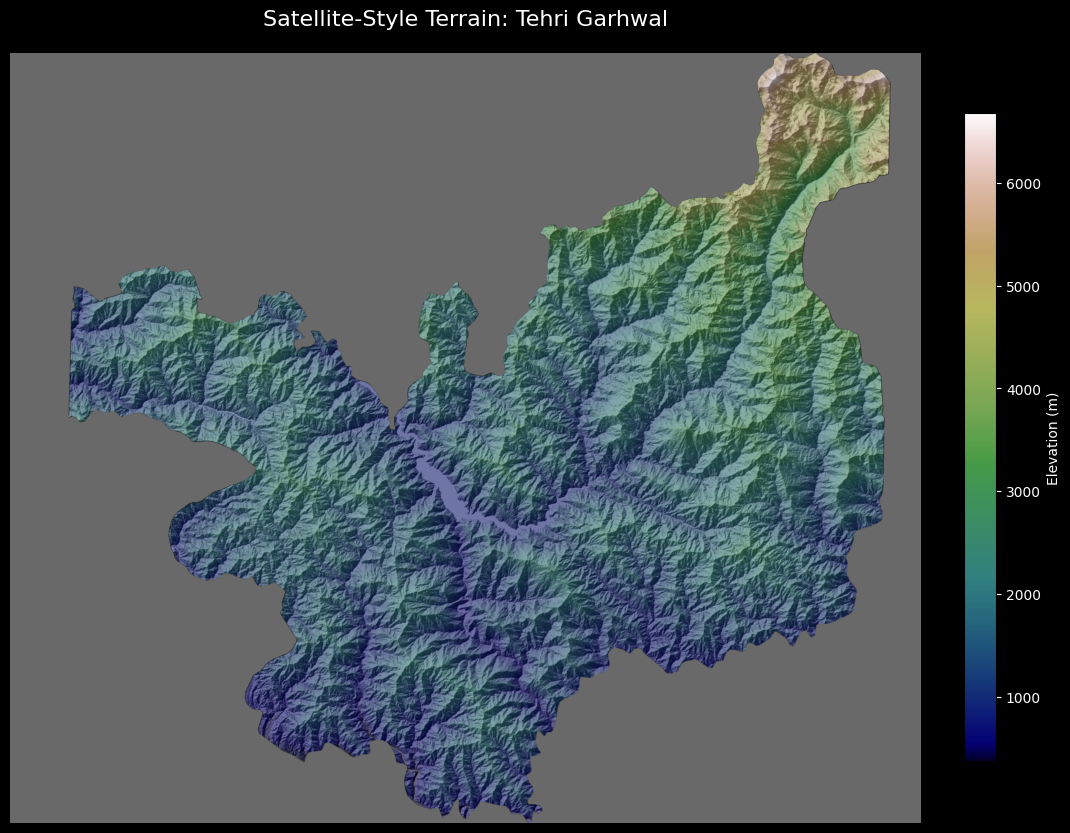

In [11]:
plt.figure(figsize=(14, 10), facecolor='black') # Dark background makes colors pop

# 1. Base Elevation Layer
# 'gist_earth' provides realistic greens, browns, and whites
img = plt.imshow(dem_clean, cmap="gist_earth", zorder=1, interpolation='bilinear')

# 2. Heavy Hillshade Overlay
# Setting alpha slightly higher (0.5) creates deeper "shadows" like a low-sun satellite shot
plt.imshow(hillshade, cmap="gray", alpha=0.5, zorder=2, interpolation='bilinear')

# 3. Aesthetics
cb = plt.colorbar(img, fraction=0.03, pad=0.04)
cb.set_label("Elevation (m)", color='white')
cb.ax.yaxis.set_tick_params(color='white', labelcolor='white')

plt.title("Satellite-Style Terrain: Tehri Garhwal", color='white', fontsize=16, pad=20)
plt.axis("off")

plt.show()

In [34]:
dem_path = "tehri_landslide/data/DEM/dem_fixed.tif"
out_path = "tehri_landslide/data/dem_features/Slope_deg.tif"

In [36]:
# cell resolution
xres = transform.a
yres = -transform.e

In [37]:
# replace nodata with NaN
dem[dem < -1000] = np.nan

In [38]:
# compute gradients
dzdx = np.gradient(dem, axis=1) / xres
dzdy = np.gradient(dem, axis=0) / yres

In [39]:
# slope in radians → degrees
slope = np.degrees(np.arctan(np.sqrt(dzdx**2 + dzdy**2)))

In [40]:
# write output
profile.update(dtype=rasterio.float32, nodata=np.nan)

In [41]:
with rasterio.open(out_path, "w", **profile) as dst:
    dst.write(slope.astype(np.float32), 1)

In [42]:
print("Slope saved:", out_path)

Slope saved: tehri_landslide/data/dem_features/Slope_deg.tif


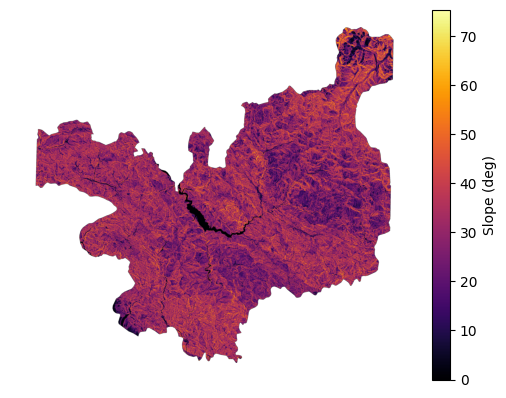

In [43]:
import matplotlib.pyplot as plt

plt.imshow(slope, cmap="inferno")
plt.colorbar(label="Slope (deg)")
plt.axis("off")
plt.show()

In [15]:
out_path_aspect = "tehri_landslide/data/dem_features/Aspect_deg.tif"

In [16]:
with rasterio.open(dem_path) as src:
    dem = src.read(1).astype(float)
    transform = src.transform
    profile = src.profile

In [17]:
# ---- Handle nodata ----
dem[dem < -1000] = np.nan

In [18]:
# ---- Cell resolution ----
xres = transform.a
yres = -transform.e

In [19]:
# ---- Gradients ----
dzdx = np.gradient(dem, axis=1) / xres
dzdy = np.gradient(dem, axis=0) / yres

In [20]:
# ---- Aspect (radians → degrees) ----
aspect = np.degrees(np.arctan2(dzdy, -dzdx))

In [21]:
# Convert -180–180 to 0–360 convention
aspect = np.where(aspect < 0, 360 + aspect, aspect)

In [22]:
# ---- Save ----
profile.update(dtype=rasterio.float32, nodata=np.nan)

In [23]:
with rasterio.open(out_path_aspect, "w", **profile) as dst:
    dst.write(aspect.astype(np.float32), 1)

In [24]:
print("Aspect saved:", out_path_aspect)

Aspect saved: tehri_landslide/data/dem_features/Aspect_deg.tif


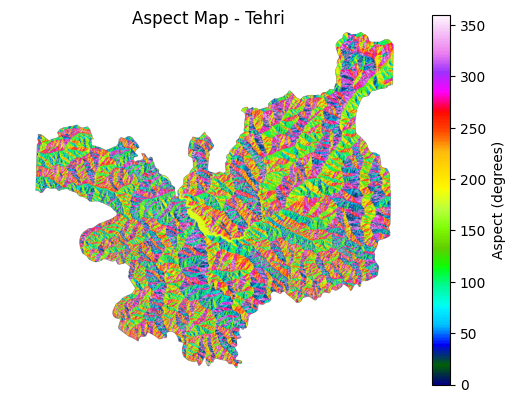

In [26]:
plt.imshow(aspect, cmap="gist_ncar")
plt.colorbar(label="Aspect (degrees)")
plt.title("Aspect Map - Tehri")
plt.axis("off")
plt.show()